<a href="https://colab.research.google.com/github/EleanorJator/Dpro_Assignments-/blob/main/Tensor_Flow-ass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

Problem 1:Looking back on scratch
To implment for deep learing;

I had to initialize weights and baises

I needed an epoch loop to train over data multiple times

I had to  initialize the nodes of each hidden layer of the network

I performed forward propagation for each layer

I needed to implement an activation function and applied it on the output of each layer

I had to implement a loss function

I had to implement back propagaiton method for the network

I had to train the model using a fit method

I had to implement an optimizer to update the values of weights and baises

I also had to implement a predict method


Problem 2:Considering  the correspondence between scratch and TensorFlow

The sample code begins by performing feature selection and data processing on the iris dataset, followed by the definition of the mini batch class. Further down, the paramters for the layers in the class were initilized and assigned values. The exmaple_net function defines the forward propagation operation for the network. Loss_op, train_op, optimizer, and accuracy are used to calculate the loss, forward, backward propagation, and accuracy of the model respectively.
The sample code is a deep learning logistic regression model implemented using tensor flow version 1. The model is trained to learn to distinguish between species of flowers, specifically iris flowers of the versicolor and virginica class.

TensorFlow version one by default uses graph computation, therefore a session has to be created for the training of the model. This session was created using the tf.session method. Within this session, the model is trained.

In [4]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [5]:
iris = load_iris()
features = iris["data"]
target = iris["target"]

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

x_train, y_train, x_test, y_test = x_train.astype(np.float32), y_train.astype(np.float32), x_test.astype(np.float32), y_test.astype(np.float32)
y_train = y_train.reshape(-1, 1)
onv = OneHotEncoder(sparse_output=False)
y_train = onv.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

Problem 3:Creating a model of Iris using all three types of objective variables

In [6]:



class Layer(tf.Module):
    def __init__(self, n_input, n_output, activation=None, name=None):
        super().__init__(name=name)
        self.weight = tf.Variable(tf.random.normal([n_input, n_output]))
        self.bais = tf.Variable(tf.random.normal([n_output]))
        self.activation = activation

    def __call__(self, x):
        y = tf.add(tf.matmul(x, self.weight), self.bais)
        if self.activation == None:
            return y
        return self.activation(y)


class LogisticRegression:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 100, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(100, 50, tf.nn.relu, "hidden1")
        self.output = Layer(50,n_classes , name="outputLayer")

    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch

            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self

    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)


def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total

In [7]:
model = LogisticRegression()
model.fit(x_train, y_train, x_val, y_val)

Num epoch: 0 loss: 56.89833450317383: loss_val: 63.21514892578125 accuracy: 0.3854166666666667
Num epoch: 1 loss: 12.312609672546387: loss_val: 72.94419860839844 accuracy: 0.6875
Num epoch: 2 loss: 8.228092193603516: loss_val: 1.5360912084579468 accuracy: 0.90625
Num epoch: 3 loss: 4.664989471435547: loss_val: 17.15325164794922 accuracy: 0.6770833333333334
Num epoch: 4 loss: 1.3043256998062134: loss_val: 4.7110514640808105 accuracy: 0.8020833333333334
Num epoch: 5 loss: 1.5706498622894287: loss_val: 0.593051016330719 accuracy: 0.9166666666666666
Num epoch: 6 loss: 1.560071349143982: loss_val: 3.445147752761841 accuracy: 0.8125
Num epoch: 7 loss: 0.6738848686218262: loss_val: 2.586683988571167 accuracy: 0.84375
Num epoch: 8 loss: 0.4909297823905945: loss_val: 0.4528981149196625 accuracy: 0.8958333333333334
Num epoch: 9 loss: 0.5314274430274963: loss_val: 0.22385574877262115 accuracy: 0.9166666666666666
Num epoch: 10 loss: 0.5670222640037537: loss_val: 0.7882450222969055 accuracy: 0.9375

In [8]:
pred = model.predict(x_test)

accuracy_score(y_test, pred)

0.9333333333333333

Text(0, 0.5, 'True value')

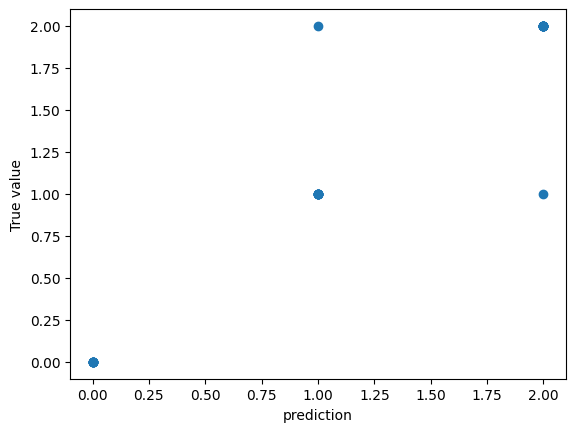

In [9]:
plt.scatter(pred, y_test)
plt.xlabel("prediction")
plt.ylabel("True value")

Problem 4: Creating a model of House Prices

In [15]:
house_train = pd.read_csv("/train.csv")

<Axes: ylabel='SalePrice'>

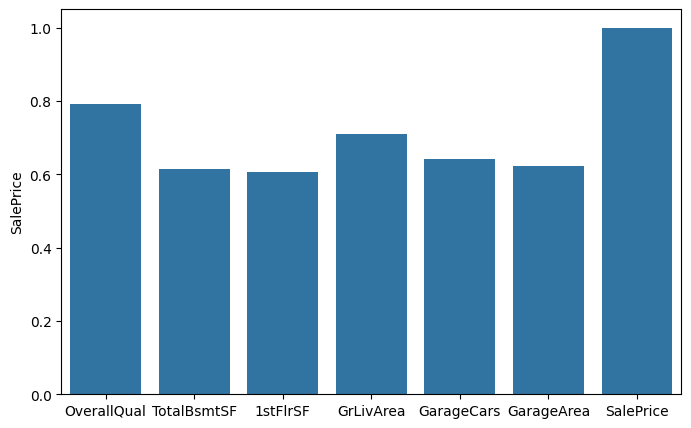

In [16]:
import seaborn as sns

test = house_train.dropna(axis=1).corr(numeric_only=True)
test = test["SalePrice"]
test = test[test > 0.6]

plt.figure(figsize=(8, 5))
sns.barplot(test)

In [25]:
class LinearRegression:
    def __init__(self, n_input=3, lr=0.001, epoch= 100, batch_size=20):
        self.lr = lr
        self.batch_size = batch_size
        self.epoch = epoch
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputLayer = Layer(n_input, 200, name= "inputLayer")
        self.middleLayer1 = Layer(200, 100, name="middleLayer")
        self.middleLayer = Layer(100, 50, name="middleLayer")
        self.outputLayer = Layer(50, 1, name="outputLayer")
        self.loss = np.array([])

    def forward(self, x):
        logit = self.inputLayer(x)
        logit = self.middleLayer1(logit)
        logit = self.middleLayer(logit)
        logit = self.outputLayer(logit)

        return logit

    def predict(self, x):
        return self.forward(x)

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train

        for i in range(self.epoch):
            totalLoss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, batch_size= self.batch_size):
                with tf.GradientTape() as tape:
                    y = self.forward(mini_x)
                    #MSE loss function
                    loss = tf.reduce_mean(tf.pow(y - mini_y, 2))
                    totalLoss += loss

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            totalLoss/=self.batch_size
            self.loss = np.append(self.loss, totalLoss)

            with tf.GradientTape() as tape:
                y = self.forward(x_val)

                loss_val = tf.reduce_mean(tf.pow(y-y_val, 2))

            gradient = tape.gradient(loss_val, y)

            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
            accuracy = accuracy_score(y_val, self.predict(x_val))

            print(f"Epoch: {i} loss: {totalLoss} Loss_val: {loss_val}")

        return self

In [26]:
linearModel = LinearRegression(epoch=100, lr=1e-5)

linearModel.fit(x_train, y_train, x_val, y_val)

Epoch: 0 loss: 18518212870144.0 Loss_val: 5776136470528.0
Epoch: 1 loss: 15410550276096.0 Loss_val: 4790937976832.0
Epoch: 2 loss: 12718133215232.0 Loss_val: 3941089411072.0
Epoch: 3 loss: 10406122749952.0 Loss_val: 3214641201152.0
Epoch: 4 loss: 8439175577600.0 Loss_val: 2599444283392.0
Epoch: 5 loss: 6782011834368.0 Loss_val: 2083648176128.0
Epoch: 6 loss: 5400356192256.0 Loss_val: 1655834935296.0
Epoch: 7 loss: 4261320065024.0 Loss_val: 1305071583232.0
Epoch: 8 loss: 3333552603136.0 Loss_val: 1021016539136.0
Epoch: 9 loss: 2587537178624.0 Loss_val: 793973555200.0
Epoch: 10 loss: 1995783012352.0 Loss_val: 614982811648.0
Epoch: 11 loss: 1533071720448.0 Loss_val: 475883470848.0
Epoch: 12 loss: 1176599134208.0 Loss_val: 369357848576.0
Epoch: 13 loss: 906109976576.0 Loss_val: 288965328896.0
Epoch: 14 loss: 703953960960.0 Loss_val: 229153734656.0
Epoch: 15 loss: 555072487424.0 Loss_val: 185242075136.0
Epoch: 16 loss: 446917967872.0 Loss_val: 153365839872.0
Epoch: 17 loss: 369237164032.0 L

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split

# Define the standardScaler function
def standardScaler(x):  # standardization
    num = x - np.mean(x)
    return num / np.std(x)

# Define the normalization function
def normalization(x):
    num = x - np.min(x)
    denum = np.max(x) - np.min(x)
    return num / denum


features = ["OverallQual", "GrLivArea", "YearBuilt"]
target = ["SalePrice"]

y = house_train[target]
x = house_train[features]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Standardization of data
# x_train = x.apply(standardScaler).to_numpy().astype(np.float32)
# y_train = y.apply(standardScaler).to_numpy().astype(np.float32)

x_train = x.to_numpy().astype(np.float32)
y_train = y.to_numpy().astype(np.float32)

# Normalization
# x_train = x.apply(normalization).to_numpy().astype(np.float32)
# y_train = y.apply(normalization).to_numpy().astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)


x_test, y_test = x_test.to_numpy().astype(np.float32), y_test.to_numpy().astype(np.float32)

Text(0, 0.5, 'true value')

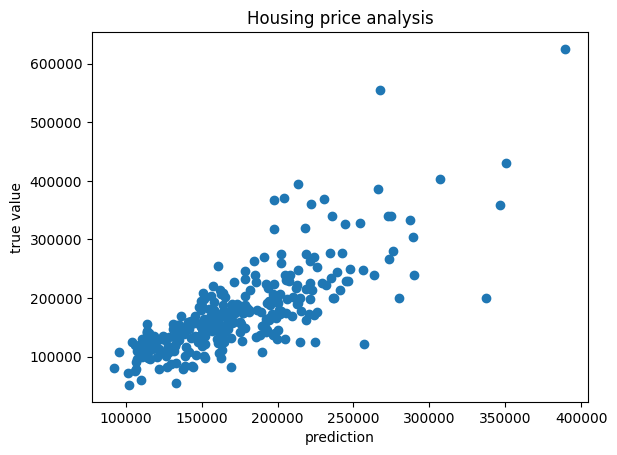

In [27]:
pred = linearModel.predict(x_test)

plt.scatter(pred, y_test)
plt.title("Housing price analysis")
plt.xlabel("prediction")
plt.ylabel("true value")

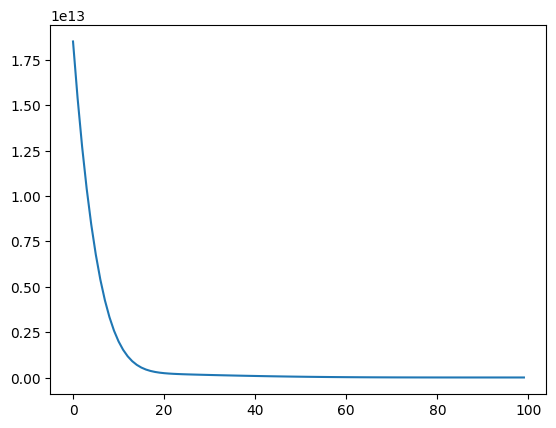

In [28]:
plt.plot(linearModel.loss)

The difference between a classification and regression problem is in the use of activation functions. In a linear regression problem, the model tries to fit the data into a straight line, an activation function is not required. However, in a classification problem an activation function is required to output into probability distribution which is used to determine the class of a dataset.

Problem 5: Creating  a model of MNIST

In [29]:
class DeepNeuralNetwork:
    def __init__(self, n_input = 4, n_classes=3,  lr=0.01, epoch=100, batch_size = 20):
        self.lr = lr
        self.epoch = epoch
        self.batch = batch_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)
        self.inputlayer = Layer(n_input, 400, tf.nn.relu, "InputLayer")
        self.hidden1 = Layer(400, 200, tf.nn.relu, "hidden1")
        self.output = Layer(200, n_classes, name="outputLayer")

    #@tf.function
    def forward(self, x):
        logit = self.inputlayer(x)
        logit = self.hidden1(logit)
        logit = self.output(logit)

        return logit

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        if x_val is None:
            x_val = x_train
            y_val = y_train
        for i in range(self.epoch):
            total_loss = 0
            for mini_x, mini_y in GetMiniBatch(x_train, y_train, self.batch):
                with tf.GradientTape() as tape:
                    logit = self.forward(mini_x)
                    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(mini_y, logit))

                gradient = tape.gradient(loss, tape.watched_variables())
                self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))
                total_loss+= loss
            total_loss/=self.batch

            with tf.GradientTape() as tape:
                logit = self.forward(x_val)
                loss_val = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_val, logit))
            accuracy = accuracy_score(np.argmax(y_train, 1), self.predict(x_train))
            gradient = tape.gradient(loss_val, tape.watched_variables())
            self.optimizer.apply_gradients(zip(gradient, tape.watched_variables()))

            print(f"Num epoch: {i} loss: {total_loss}: loss_val: {loss_val} accuracy: {accuracy}")
        return self

    def predict(self, x):
        y = tf.nn.softmax(self.forward(x)).numpy()

        return np.argmax(y, 1)


def accuracy_score(y_true, pred):
    correct = np.sum(np.round(y_true) == np.round(pred))
    total = y_true.shape[0]
    return correct/total

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)
x_train, x_test = x_train.reshape(-1, 784).astype(np.float32), x_test.reshape(-1, 784).astype(np.float32)

x_train /= 255
x_test /= 255

y_train = onv.fit_transform(y_train)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

11490434/11490434 [==============================] - 0s 0us/step


In [31]:
x_train.shape
#y_train.shape
n_input = x_train.shape[1]
n_classes = y_train.shape[1]

In [32]:
model = DeepNeuralNetwork(lr=0.001, n_input=n_input, n_classes=n_classes, epoch=10).fit(x_train, y_train, x_val, y_val)

Num epoch: 0 loss: 10857.84765625: loss_val: 35.24251174926758 accuracy: 0.9139375
Num epoch: 1 loss: 2716.29248046875: loss_val: 24.111499786376953 accuracy: 0.9392083333333333
Num epoch: 2 loss: 1408.871826171875: loss_val: 19.225786209106445 accuracy: 0.9582291666666667
Num epoch: 3 loss: 846.8190307617188: loss_val: 17.311119079589844 accuracy: 0.9645833333333333
Num epoch: 4 loss: 547.4575805664062: loss_val: 15.793649673461914 accuracy: 0.9748958333333333
Num epoch: 5 loss: 381.4927062988281: loss_val: 15.90805435180664 accuracy: 0.9742916666666667
Num epoch: 6 loss: 291.3869323730469: loss_val: 14.274033546447754 accuracy: 0.9808958333333333
Num epoch: 7 loss: 244.16238403320312: loss_val: 12.920646667480469 accuracy: 0.9854791666666667
Num epoch: 8 loss: 208.2257843017578: loss_val: 12.324956893920898 accuracy: 0.9909791666666666
Num epoch: 9 loss: 165.0340576171875: loss_val: 14.385427474975586 accuracy: 0.9842291666666667


In [33]:
pred = model.predict(x_test)

In [34]:
print(pred.shape)
y_test.shape

(10000,)


(10000, 1)

In [35]:
from sklearn.metrics import confusion_matrix, accuracy_score

confusion_matrix(y_test, pred)

array([[ 970,    0,    0,    0,    0,    0,    4,    1,    4,    1],
       [   1, 1118,    4,    3,    0,    0,    3,    0,    4,    2],
       [   8,    2,  986,    4,    7,    0,    5,    7,   11,    2],
       [   1,    0,   16,  941,    2,    9,    1,    6,   11,   23],
       [   2,    0,    3,    0,  943,    0,    7,    2,    1,   24],
       [   9,    1,    2,   13,    6,  821,   12,    2,   19,    7],
       [  14,    2,    1,    1,    5,    2,  925,    1,    6,    1],
       [   1,    5,   10,    6,    4,    1,    0,  942,    7,   52],
       [  10,    1,    7,    6,   10,    3,    9,    3,  901,   24],
       [   7,    3,    0,    3,   12,    1,    1,    4,    4,  974]])

In [36]:
accuracy_score(y_test, pred)

0.9521